In [69]:
%matplotlib inline  
# Load the libraries
import glob2, re
import pandas as pd
import numpy as np
import json
import networkx as nx
import community as comm
from collections import Counter
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap

# Color palette for figures 

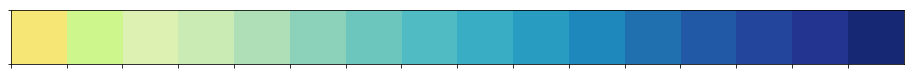

In [8]:
color_map = sns.color_palette("YlGnBu", n_colors=len(ROBOT_RANGE))
color_map = color_map.as_hex()
color_map[0] = '#f5e675'
color_map[1] = '#cdf68d'

#color_map = sns.cubehelix_palette(n_colors=len(ROBOT_RANGE), light=0.7, rot=-0.4)

linestyles = ['-', '--', '-.', ':', '-']
markers=['x', ',', '^', 'o', '.']
loosely_dotted = (0, (5,10))
linestyles = ['solid','dashed','dashdot','dotted',loosely_dotted]
sns.palplot(color_map)

#  Finishing Time and Success Rate Functions

In [3]:
def FinishingTimesFirstToCompleteMerkleTree(NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, DENSITY_OF_TOKENS, THRESHOLD, FILES):
   
    frame = pd.DataFrame()
    csv_columns = []
    sims_set_list = []

    regex = re.compile(r'R' + str(NUMBER_OF_ROBOTS) + '/' + 'T'+ str(NUMBER_OF_TOKENS) + '/' + 'D'+ DENSITY_OF_TOKENS)
    selected_files = filter(regex.search, FILES) 
        
    # load merkle completed column into dataframe
    for x, file_ in enumerate(selected_files):
        df = pd.read_csv(file_, index_col=None, delimiter='\t', header=0, names=['time','merkle_completed-SIM' + str(x)])
        csv_columns.append(df['merkle_completed-SIM' + str(x)])
        frame = pd.concat(csv_columns,axis=1)
        
    # find the last element of the column
    for x in range(np.size(frame.columns)):
        column_sim_id = 'merkle_completed-SIM' + str(x)
        array_with_nan = frame[column_sim_id].index[frame[column_sim_id].apply(pd.isnull)]
        col_dimension = frame[column_sim_id].count() + 1
        
        # If there is no NaN just check if it is lower than threshold
        if array_with_nan.empty:
            if (col_dimension < THRESHOLD):
                first_robot_timestamp = frame[column_sim_id].index[frame[column_sim_id]>0][0] + 2
                sims_set_list.append(first_robot_timestamp)
            else:
                sims_set_list.append(np.nan)
            
        # If there is NaN just get the first one
        else:
            sims_set_list.append(min(array_with_nan)+1)

    return sims_set_list

In [4]:
def FinishingTimesLastToCompleteMerkleTree(NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, DENSITY_OF_TOKENS, THRESHOLD, FILES):

    frame = pd.DataFrame()
    csv_columns = []
    sims_set_list = []

    regex = re.compile(r'R' + str(NUMBER_OF_ROBOTS) + '/' + 'T'+ str(NUMBER_OF_TOKENS) + '/' + 'D'+ DENSITY_OF_TOKENS)
    selected_files = filter(regex.search, FILES) 
        
    # load merkle completed column into dataframe
    for x, file_ in enumerate(selected_files):
        df = pd.read_csv(file_, index_col=None, delimiter='\t', header=0, names=['time','merkle_completed-SIM' + str(x)])
        csv_columns.append(df['merkle_completed-SIM' + str(x)])
        frame = pd.concat(csv_columns,axis=1)
        
    # find the last element of the column
    for x in range(np.size(frame.columns)):
        column_sim_id = 'merkle_completed-SIM' + str(x)
        array_with_nan = frame[column_sim_id].index[frame[column_sim_id].apply(pd.isnull)]
            
        # If there is no NaN just check if it is lower than threshold
        if array_with_nan.empty:
            col_dimension = frame[column_sim_id].count() + 1    
            if (col_dimension < THRESHOLD):
                sims_set_list.append(col_dimension)
            else:
                sims_set_list.append(np.nan)
            
        # If there is NaN just get the first one
        else:
            sims_set_list.append(min(array_with_nan)+1)

    return sims_set_list

In [5]:
def CompletionSuccess(THRESHOLD, FINISHING_TIMES):

    filtered_times = []

    for t in range(0,THRESHOLD):
        filtered_times.append(len([i for i in FINISHING_TIMES if i <= t]))
  
    return np.true_divide(np.array(filtered_times), len(FINISHING_TIMES))

#  Foraging Mission Analysis Sequential

In [74]:
# Specify the file paths and the list of all sim data files 
path=r'/Users/eddie/foraging-epuck-sim-last-100-iterations/' # use your path
ALL_FILES = glob2.glob(path + "/*/*/*/*/*.dat")

# Filter up to what simulation do you want to consider
SIM_THRESHOLD = 100
for _file in ALL_FILES:
    substring = re.findall(r'SIM\d+', _file)
    current_sim_number = substring[0].strip('SIM')
    if int(current_sim_number) > SIM_THRESHOLD:
        ALL_FILES.remove(_file)

In [208]:
# Specify the search terms for filtering the files
ROBOT_RANGE = range(1,17)
TOKEN_RANGE = range(4,9)
DENSITY_OF_TOKENS = '\d'
TIMEOUT_THRESHOLD = 21000

# Matrix Creation
FINISHING_TIMES = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]
SUCCESS_PERCENTAGES = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]

pairs = [(i,j) for i in range(len(ROBOT_RANGE)) for j in range(len(TOKEN_RANGE))]

# Matrix Value Calculation
for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):
    for y, NUMBER_OF_TOKENS in enumerate(TOKEN_RANGE):
        FINISHING_TIMES[x][y] = FinishingTimesFirstToCompleteMerkleTree(NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, DENSITY_OF_TOKENS, TIMEOUT_THRESHOLD, ALL_FILES)
        SUCCESS_PERCENTAGES[x][y] = CompletionSuccess(TIMEOUT_THRESHOLD, FINISHING_TIMES[x][y])

## Figure Probability of Success for all configuration (All lines)

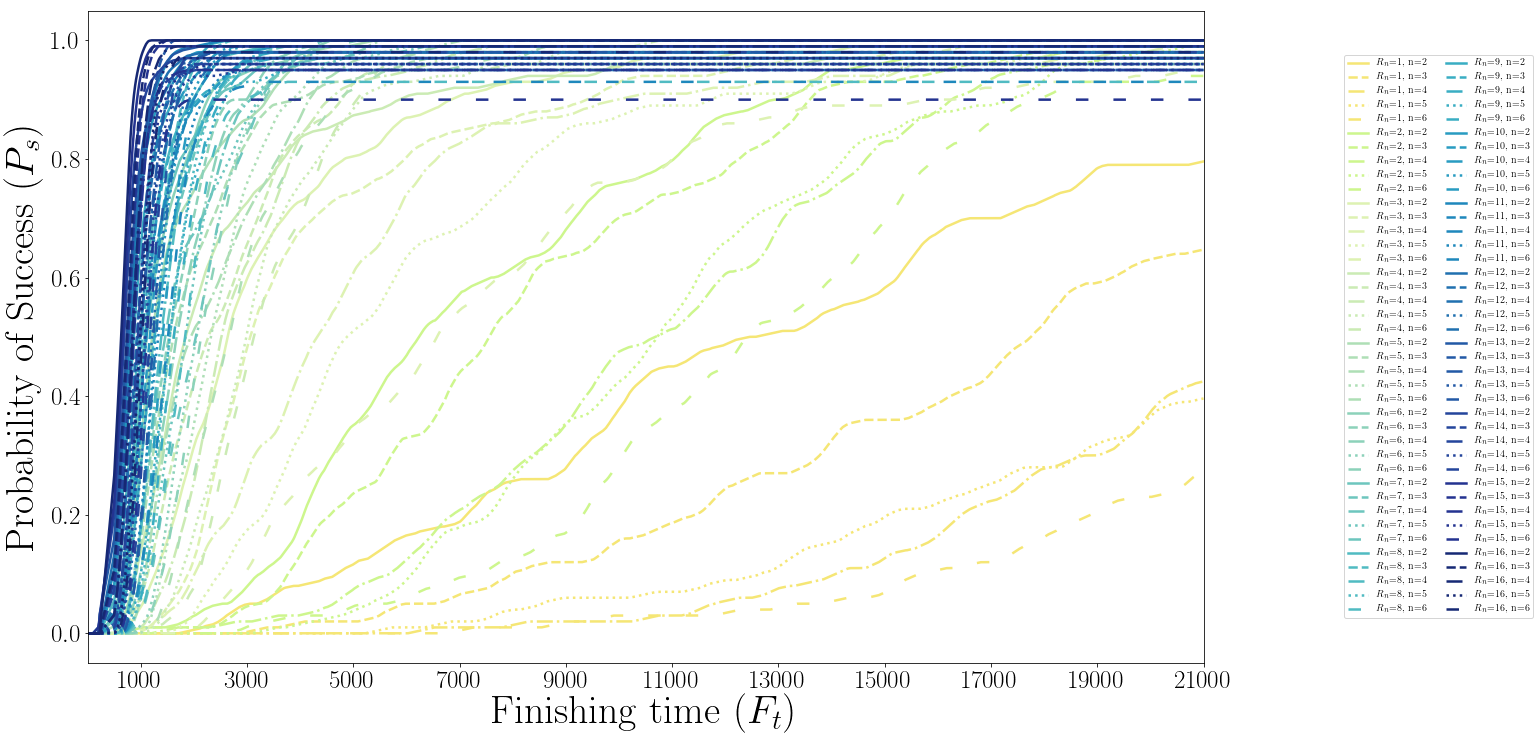

In [206]:
def interpolate(xnew, pair, SUCCESS_PERCENTAGES):
    xnew[0][225] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][225]
    xnew[0][200] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][200]
    xnew[0][100] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][100]
    xnew[0][0] = SUCCESS_PERCENTAGES[pair[0]][pair[1]][0]
    return xnew

# Success rate calculation
plt.figure(figsize=(20,12))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

for pair in pairs:
    xnew = pd.DataFrame(SUCCESS_PERCENTAGES[pair[0]][pair[1]]).rolling(500).mean()
    xnew = interpolate(xnew, pair, SUCCESS_PERCENTAGES)
    xnew = xnew.interpolate()
    xnew.dropna(inplace=True)
    #plt.plot(xnew, color=color_map[pair[0]], ls=linestyles[pair[1]], label = "_nolegend")
    plt.plot(xnew, color=color_map[pair[0]], lw=2.5, ls=linestyles[pair[1]], label= str(r'$R_{n}$='+ str(pair[0]+1) + ', n=' + str(pair[1]+min(TOKEN_RANGE))))
              
plt.tick_params(labelsize=25)
plt.xticks([i*1000 for i in range(1,22, 2)])
plt.xlim([0,TIMEOUT_THRESHOLD])
plt.xlabel('Finishing time' + ' ' + r'$(F_{t})$', fontsize=40)
plt.ylabel('Probability of Success' + ' ' + r'$(P_{s})$', fontsize=40, fontweight='bold')

legend_properties = {'size': 10, 'weight': 'bold'}
plt.legend(ncol=2, loc="right", prop=legend_properties,  bbox_to_anchor=(1.30, 0.5))
plt.show()

## Figure Probability of Success for all configuration (Mean lines)

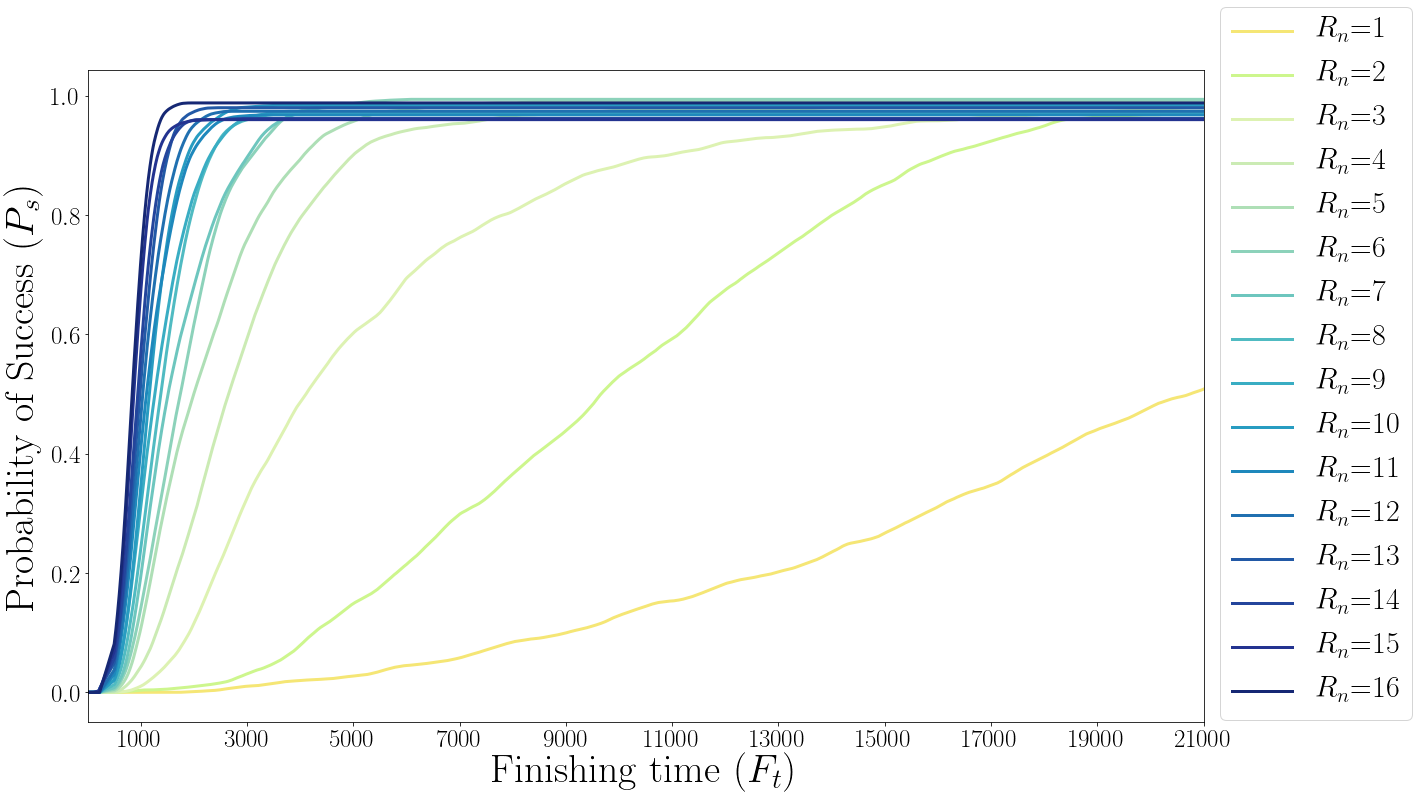

In [77]:
def interpolate(xnew, pair, xnew_mean):
    xnew[225] = xnew_mean[225]
    xnew[200] = xnew_mean[200]
    xnew[100] = xnew_mean[100]
    xnew[0] = xnew_mean[0]
    return xnew

plt.figure(figsize=(20,12))

for pair in range(len(ROBOT_RANGE)):
    all_xs = pd.DataFrame(SUCCESS_PERCENTAGES[pair])
    xnew_mean = all_xs.mean(axis=0)
    xnew = xnew_mean.rolling(500).mean()
    xnew = interpolate(xnew, pair, xnew_mean)
    xnew = xnew.interpolate()
    plt.plot(xnew, color=color_map[pair], ls=linestyles[0], lw=3, label = str(r'$R_{n}$='+ str(pair+1)))
    plt.legend(prop={'weight':'bold'})

plt.tick_params(labelsize=25)
plt.xticks([i*1000 for i in range(1,22, 2)])
plt.xlabel('Finishing time' + ' ' + r'$(F_{t})$', fontsize=40)
plt.ylabel('Probability of Success' + ' ' + r'$(P_{s})$', fontsize=40, fontweight='bold')
plt.xlim([0,TIMEOUT_THRESHOLD])
legend_properties = {'size': 30, 'weight': 'bold'}
plt.legend(ncol=1,loc="right", prop=legend_properties, bbox_to_anchor=(1.20, 0.55))
plt.show()

## Probability of Success for all configuration (Mean lines with confidence values)

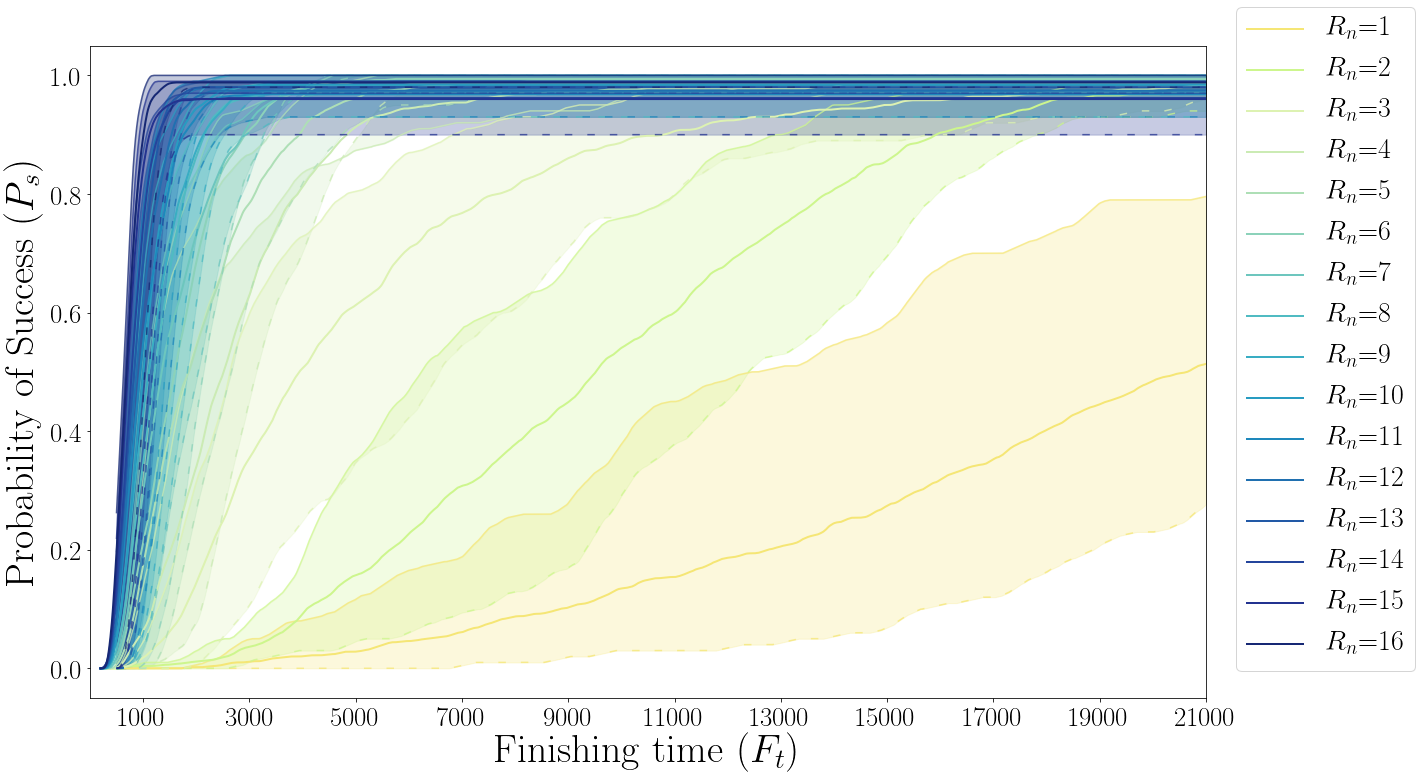

In [78]:
plt.figure(figsize=(20,12))
for pair in range(len(ROBOT_RANGE)):
    # get array for group size 
    all_xs = pd.DataFrame(SUCCESS_PERCENTAGES[pair])
    
    # get borders
    min_ = all_xs.T[0].rolling(500).mean()
    max_ = all_xs.T[4].rolling(500).mean()
    plt.plot(min_, color= color_map[pair],alpha=0.75, ls=linestyles[0], label='_nolegend_')
    plt.plot(max_, color= color_map[pair],alpha=0.75, ls=linestyles[-1], label='_nolegend_')
    plt.fill_between(range(len(min_)),min_,max_,alpha=0.25, color=color_map[pair])
    
    # plot average 
    xnew = all_xs.mean(axis=0)
    xnew = xnew.rolling(200).mean()
    xnew.dropna(inplace=True)
    plt.plot(xnew, 
             color=color_map[pair],
             label = str(r'$R_{n}$='+ str(pair+1)),lw=2)

legend_properties = {'size': 28, 'weight': 'bold'}
plt.tick_params(labelsize=27)
plt.xticks([i*1000 for i in range(1,22, 2)])
plt.xlabel('Finishing time' + ' ' + r'$(F_{t})$', fontsize=40)
plt.ylabel('Probability of Success' + ' ' + r'$(P_{s})$', fontsize=40, fontweight='bold')
plt.xlim([0,TIMEOUT_THRESHOLD])
plt.legend(ncol=1,loc="right", prop=legend_properties, bbox_to_anchor=(1.20, 0.55))
plt.show()

### Probability of Success for specific configurations (all lines in a conf)

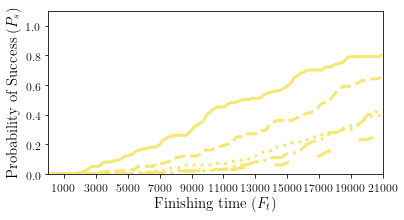

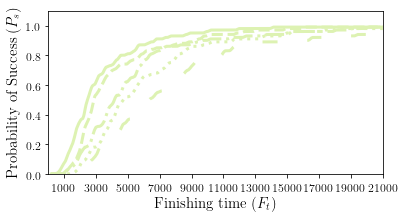

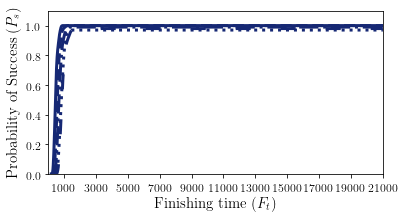

In [212]:
def min_plots(num_bots):
    plt.figure(figsize=(6,3))
    ind = pairs[(num_bots-1)*len(TOKEN_RANGE):(num_bots)*len(TOKEN_RANGE)]
        
    for pair in ind:
        xnew = pd.DataFrame(SUCCESS_PERCENTAGES[pair[0]][pair[1]]).rolling(200).mean()
        xnew.dropna(inplace=True)
        plt.plot(xnew, color=color_map[pair[0]], ls=linestyles[pair[1]], lw=3)
        
    plt.xlabel('Finishing time' + ' ' + r'$(F_{t})$', fontsize=15)
    plt.ylabel('Probability of Success' + ' ' + r'$(P_{s})$', fontsize=15)
    plt.xticks([i*1000 for i in range(1,22, 2)])
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.axis([0, TIMEOUT_THRESHOLD, 0, 1.1])
    plt.show()
    
min_plots(min(ROBOT_RANGE))
min_plots(len(ROBOT_RANGE)/2 - 5)
min_plots(max(ROBOT_RANGE))

## Figure for finishing time for all configurations (All bars)

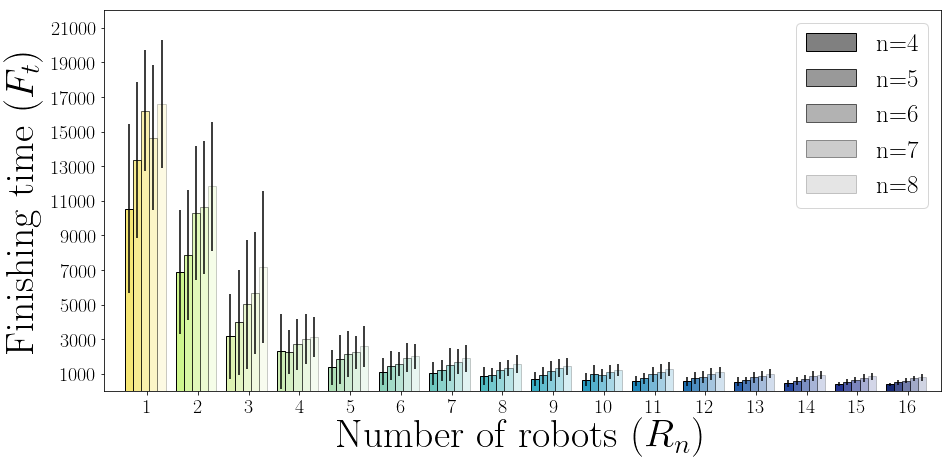

In [80]:
# Finishing Time Calculation
plt.figure(figsize=(15,7))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

bar_width = 0.16
opacity = 0.4

for y, NUMBER_OF_TOKENS in enumerate(TOKEN_RANGE):
    robot_array =[d2[y] for d2 in [d1[:] for d1 in FINISHING_TIMES]]
    rr = np.array(ROBOT_RANGE)
    plt.bar(rr+(bar_width*y), list(map(np.nanmean, zip(robot_array))), bar_width, yerr=list(map(np.nanstd, zip(robot_array))), label='n='+str(NUMBER_OF_TOKENS), color=color_map,  edgecolor='k', lw=1, alpha=1-(y*0.2))
    plt.legend(loc=1, prop={'size': 25})

ax = plt.gca()
leg = ax.get_legend()
for y, NUMBER_OF_TOKENS in enumerate(TOKEN_RANGE):
    leg.legendHandles[y].set_color('grey')
    leg.legendHandles[y].set_edgecolor('black')
    
plt.tick_params(labelsize=20)
plt.xticks(rr+0.36, tuple((i) for i in ROBOT_RANGE))
plt.xlabel('Number of robots' + ' ' + r'$(R_{n})$' , fontsize=40)
plt.yticks([i*1000 for i in range(1,22, 2)])
plt.ylabel('Finishing time' + ' ' + r'$(F_{t})$', fontsize=40)
plt.axis([min(ROBOT_RANGE)-0.5, max(ROBOT_RANGE) + 1, 0, TIMEOUT_THRESHOLD+1000])
plt.show()

## Communication Cost and Information diversity

In [94]:
# Specify the search terms for filtering the files
ROBOT_RANGE = range(1,17)
TOKEN_RANGE = [2,4,5,6,7,8]
DENSITY_OF_TOKENS = '\d'
TIMEOUT_THRESHOLD = 21000

# Specify the file paths and the list of all sim data files 
path=r'/Users/eddie/foraging-epuck-sim-last-100-iterations/' # use your path
ALL_FILES_JSON = glob2.glob(path + "/*/*/*/*/*.json")

# Filter up to what simulation do you want to consider
SIM_THRESHOLD = 100
for _file in ALL_FILES_JSON:
    substring = re.findall(r'SIM\d+', _file)
    current_sim_number = substring[0].strip('SIM')
    if int(current_sim_number) > SIM_THRESHOLD:
        ALL_FILES_JSON.remove(_file)

In [95]:
# get_size function
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [96]:
# function to get unique values 
def unique(list1): 
    x = np.array(list1)
    return np.unique(x)

In [97]:
def FinishingTimeFirstRobotToCompleteMerkleTree(file_, THRESHOLD):

    file_ = file_.replace('adjacency_matrix','sim')   
    file_ = file_.replace('json','dat')  
    
    df = pd.read_csv(file_, index_col=None, delimiter='\t', header=0, names=['time','merkle_completed'])
    array_with_nan = df.index[df['merkle_completed'].apply(pd.isnull)]
    col_dimension = df.count() + 1
        
    # If there is no NaN just check if it is lower than threshold
    if array_with_nan.empty:
        if (col_dimension.time < THRESHOLD):
            first_robot_timestamp = min(df.index[df.merkle_completed>0] + 2)
            return first_robot_timestamp
        else:
            return np.nan
            
        # If there is NaN just get the first one
    else:
        return min(array_with_nan)+1


def ExtractCommunicationGraphEndOfExperiment(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_LEAVES, SIM_FILE):    
    data = pd.read_json(SIM_FILE)
    rows, columns = data.shape
    G = nx.DiGraph()

    for robotid in xrange(INITIAL_ID, INITIAL_ID + NUMBER_OF_ROBOTS):
        G.add_node(robotid)
        from_robots = data['robots'][rows-1][robotid - INITIAL_ID]['mk']['from_robot']           
        for other_robot in unique(from_robots):
            G.add_edge(other_robot, robotid, weight=Counter(from_robots)[other_robot])          
    return G

def ExtractCommunicationGraphFirstRobotToCompleteMerkleTree(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_LEAVES, SIM_FILE):    
    data = pd.read_json(SIM_FILE)
    time_to_complete_first_merkle = FinishingTimeFirstRobotToCompleteMerkleTree(SIM_FILE,TIMEOUT_THRESHOLD)
    G = nx.DiGraph()
    if not np.isnan(time_to_complete_first_merkle):
        for robotid in xrange(INITIAL_ID, INITIAL_ID + NUMBER_OF_ROBOTS):
            G.add_node(robotid)
            from_robots = data['robots'][time_to_complete_first_merkle-1][robotid - INITIAL_ID]['mk']['from_robot']           
            for other_robot in unique(from_robots):
                G.add_edge(other_robot, robotid, weight=Counter(from_robots)[other_robot])          
    return G

In [98]:
def CommunicationCostCalculation(G, NUMBER_OF_LEAVES, HASH_SIZE_IN_BYTES):  
    number_of_iterations = sum(nx.get_edge_attributes(G,'weight').values())    
    if (number_of_iterations!=0):
        return sum(nx.get_edge_attributes(G,'weight').values()) * (np.log2(NUMBER_OF_LEAVES) + 2) * HASH_SIZE_IN_BYTES
    else:
        return np.nan

In [99]:
def CommunicationCostinKB(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, HASH_SIZE_IN_BYTES, FILTERED_FILES):
    CC = []
    GR = []
    for x, file in enumerate(FILTERED_FILES):
        GR.append(ExtractCommunicationGraphFirstRobotToCompleteMerkleTree(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, file))
        CC.append(CommunicationCostCalculation(GR[-1], NUMBER_OF_TOKENS, HASH_SIZE_IN_BYTES)/1024)
    return GR, CC

In [100]:
def sdi(data):
    from math import log as ln
    
    def p(n, N):
        if n is  0:
            return 0
        else:
            return (float(n)/N) * ln(float(n)/N)
            
    N = sum(data)
    return -sum(p(n, N) for n in data if n is not 0)

In [101]:
def PrivacyCoeff(NUMBER_OF_ROBOTS,NUMBER_OF_TOKENS, FILTERED_FILES):

    object_list = []
    Pr = []
        
    for x, file in enumerate(FILTERED_FILES):
        data = pd.read_json(file)
        object_list.append(data)
        
    for y in range(len(object_list)):
        number_of_robots = len(object_list[y]['robots'][0])
        experiment_finishing_time = len(object_list[y]) - 1
        by_all_robots_in_sim = []

        for robotid in range(number_of_robots):
            by_this_robot = len(object_list[y]['robots'][experiment_finishing_time][robotid]['mk']['by_robot'])
            by_all_robots_in_sim.append(by_this_robot)

        if sum(by_all_robots_in_sim)==NUMBER_OF_TOKENS:
            Pr.append(sdi(by_all_robots_in_sim)/np.log(NUMBER_OF_TOKENS))

    return Pr

In [102]:
CC = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]
PR = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]
GR = [[[] for i in range(len(TOKEN_RANGE))] for i in range(len(ROBOT_RANGE))]

HASH_SIZE_IN_BYTES = 32
INITIAL_ID = 20

# Matrix Value Calculation
for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):
    for y, NUMBER_OF_TOKENS in enumerate(TOKEN_RANGE):    
        regex = re.compile(r'R' + str(NUMBER_OF_ROBOTS) + '/' + 'T'+ str(NUMBER_OF_TOKENS) + '/' + 'D'+ str(DENSITY_OF_TOKENS))
        FILTERED_FILES = filter(regex.search, ALL_FILES_JSON)                
        GR[x][y], CC[x][y] = CommunicationCostinKB(INITIAL_ID, NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, HASH_SIZE_IN_BYTES, FILTERED_FILES)
        PR[x][y] = PrivacyCoeff(NUMBER_OF_ROBOTS, NUMBER_OF_TOKENS, FILTERED_FILES)

## Figure communication cost for different merkle tree lengths and information diversity

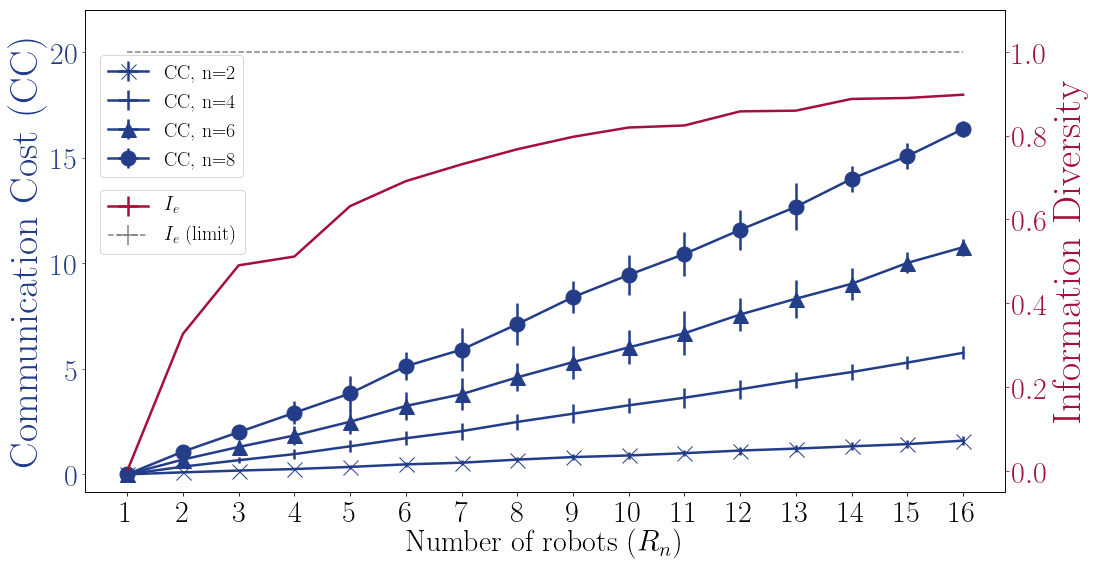

In [185]:
# Communication Cost Vs Information Diversity
fig, ax1 = plt.subplots(figsize=(15,8))

task_range = [0, 1, 3, 5]
task_id = [2, 4, 6, 8]

for y, task in enumerate(task_range):
    
    robot_row = []
    robot_row_std = []
    
    for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):
        if NUMBER_OF_ROBOTS == 1:
            robot_row.append(0)
            robot_row_std.append(0)
        else:
            robot_row.append(np.nanmean(CC[x][task]))
            robot_row_std.append(np.nanstd(CC[x][task]))

    ax1.errorbar(ROBOT_RANGE, robot_row, xerr=0, yerr=robot_row_std, color='#233D89', markersize=15, marker=markers[y], label=str('CC, n=' + str(task_id[y])), lw=2.5)

ax1.set_xlabel('Number of robots' + ' ' +  r'$(R_{n})$', fontsize=30)

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Communication Cost (CC)', color='#233D89', fontsize=40)
ax1.tick_params('y', colors='#233D89')
ax1.set_ylim(top=22.0)
plt.xticks(tuple((i) for i in ROBOT_RANGE))
plt.tick_params(labelsize=30)
plt.legend(loc='center left',prop={'size': 20}, bbox_to_anchor=(0.005, 0.78))

ax2 = ax1.twinx()

robot_row = []
robot_row_std = []

for x, NUMBER_OF_ROBOTS in enumerate(ROBOT_RANGE):
    
    if NUMBER_OF_ROBOTS == 1:
        robot_row.append(0)
        robot_row_std.append(0)
    else:    
        test = [item for sublist in PR[x] for item in sublist]
        robot_row.append(np.nanmean(test))
        robot_row_std.append(np.nanstd(test))

ax2.errorbar(ROBOT_RANGE, robot_row, xerr=0, yerr=0, c='#A4103B', markersize=20, label=str(r'$I_{e}$'), lw=2.5) 
ax2.set_ylabel('Information Diversity', color='#A4103B', fontsize=40)
ax2.tick_params('y', colors='#A4103B')

# Limit for Privacy
ax2.errorbar(range(1,17), np.ones(16), xerr=0, yerr=0, c='grey', ls='dashed', markersize=20, label=str(r'$I_{e}$ (limit)')) 

ax2.set_ylim(top=1.1)
fig.tight_layout()
plt.tick_params(labelsize=30)
plt.legend(loc='center left',prop={'size': 20}, bbox_to_anchor=(0.005, 0.56))
plt.show()

### Figure information diversity distributions for different task numbers

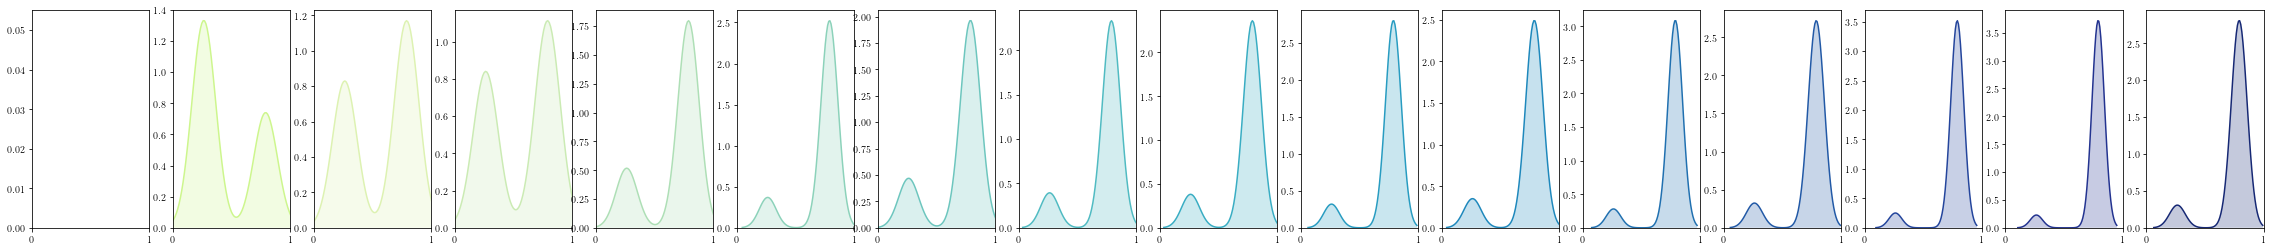

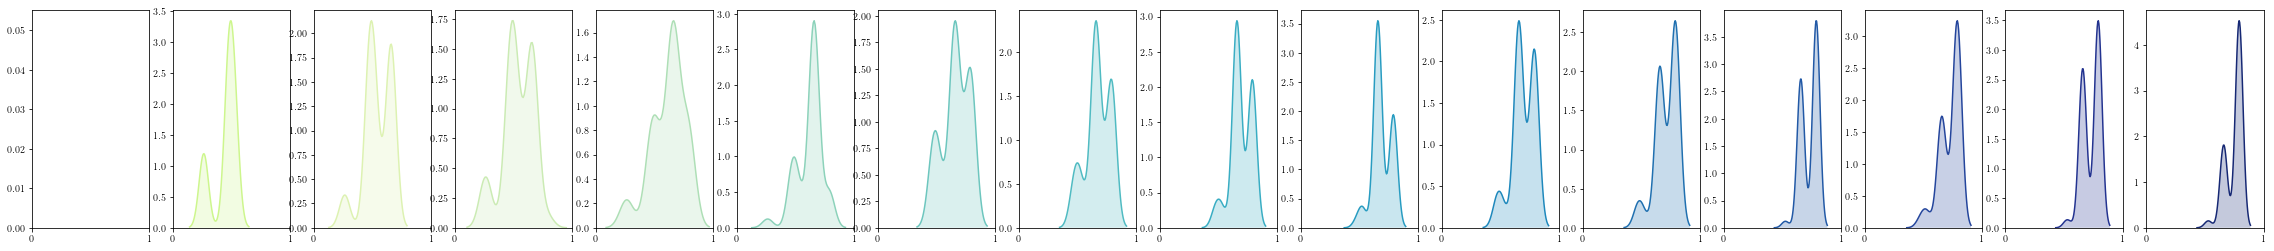

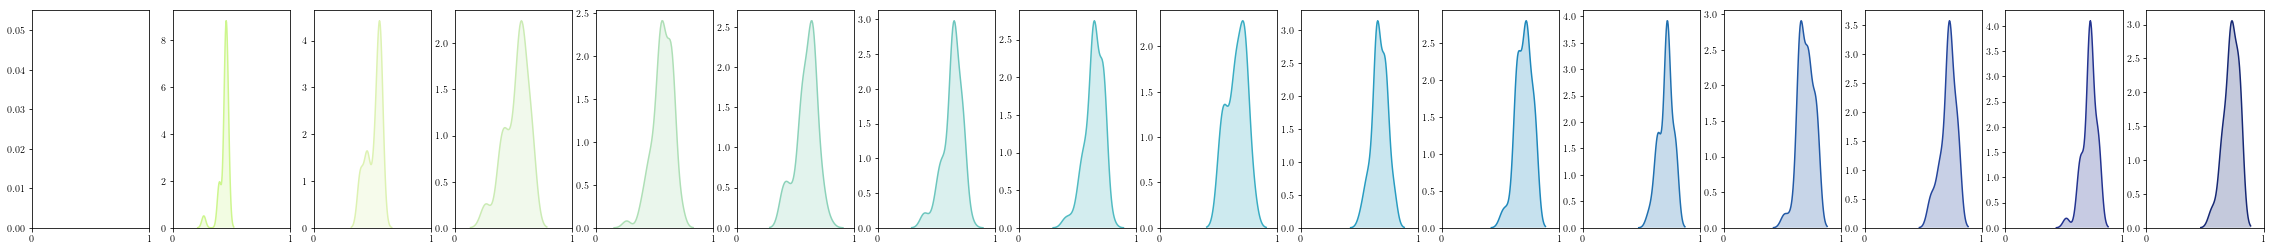

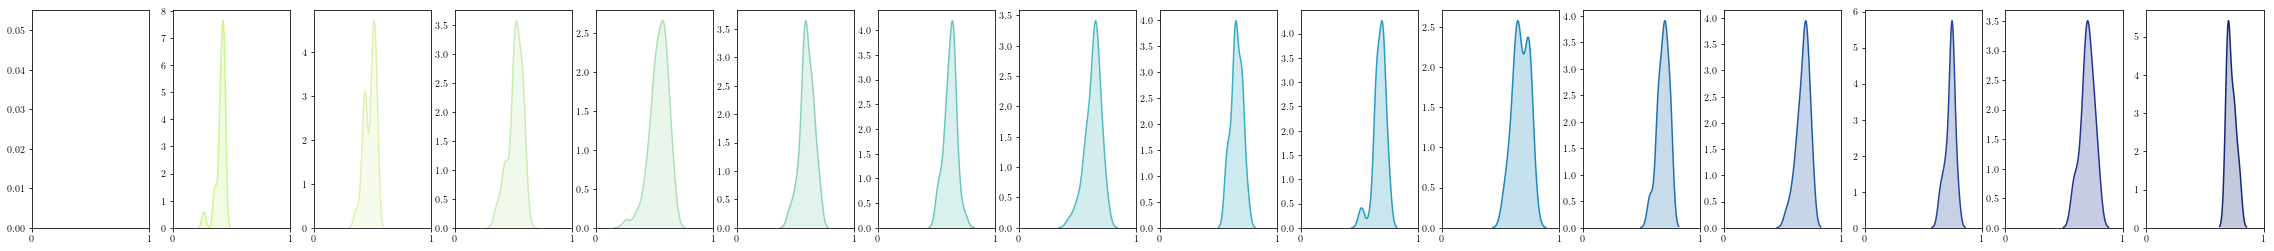

In [202]:
for y, task in enumerate(task_range):
    fig, ax = plt.subplots(nrows=1, ncols=max(ROBOT_RANGE), figsize=(40,4), sharex=True)
    
    for x in range(0, max(ROBOT_RANGE),1):
        sns.distplot(PR[x][task], color=color_map[x], kde_kws={"shade": True}, kde=True, hist=False, ax=ax[x])
        plt.xlim([-0.5, 1.4])
        plt.xticks([-0.5,1.4],[0,1])
#         plt.ylim([0,5])
#         plt.axis('off')
#         plt.plot([1.4]*8,[-0.5+(j)*0.5 for j in range(8)], '--',color='grey')
#         plt.savefig('info_div_%d_robots_%d_tasks.png' % ((x+1), y), bbox_inches='tight', dpi=200)
#         print('./%d_robots_%d_tasks.png' % ((i+1),1))


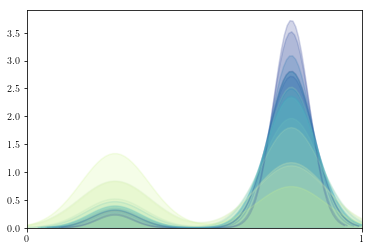

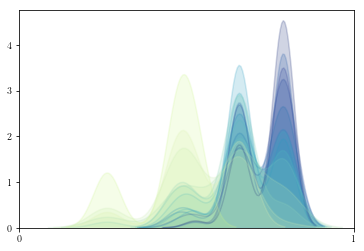

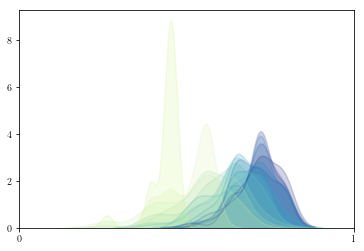

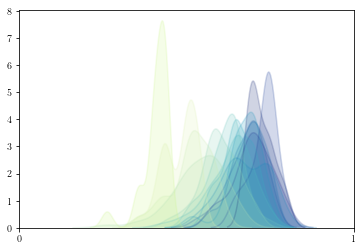

In [204]:
for y, task in enumerate(task_range):
    fig, ax = plt.subplots()
    for x in reversed([i for i in range(max(ROBOT_RANGE))]):
        sns.distplot(PR[x][task], color=color_map[x], kde_kws={"shade": True, 'alpha':0.2}, kde=True, hist=False)
        plt.xlim([-0.5, 1.4])
        plt.xticks([-0.5,1.4],[0,1])
    #plt.savefig('info_div_%d_robots_%d_tasks.png' % ((x+1), y), bbox_inches='tight', dpi=600)

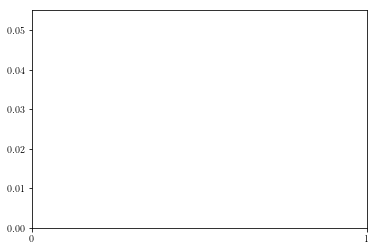

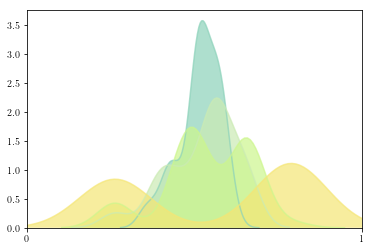

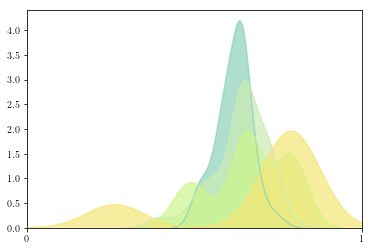

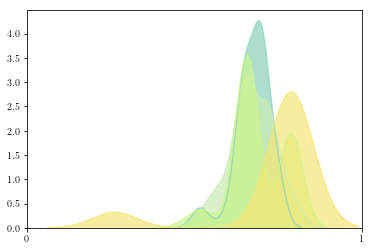

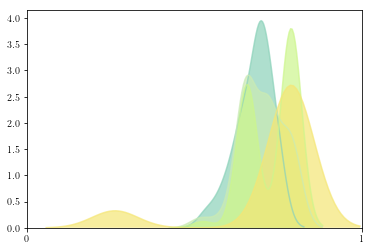

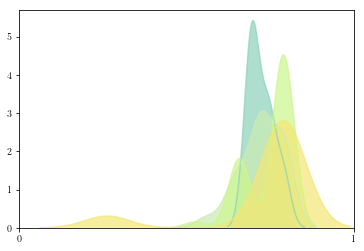

In [205]:
for x in range(0, max(ROBOT_RANGE),3):
    fig, ax = plt.subplots()
    for y in reversed([i for i in task_range]):
        sns.distplot(PR[x][y], color=color_map[y], kde_kws={"shade": True, 'alpha':0.7}, kde=True, hist=False)
        plt.xlim([-0.5, 1.4])
        plt.xticks([-0.5,1.4],[0,1])
    plt.savefig('info_div_%d_robots_%d_tasks.png' % ((x+1), y), bbox_inches='tight', dpi=600)

In [73]:
SIMULATION_FORAGING_GR = GR
SIMULATION_FORAGING_FINISHING_TIMES = FINISHING_TIMES

%store SIMULATION_FORAGING_GR
%store SIMULATION_FORAGING_FINISHING_TIMES

Stored 'SIMULATION_FORAGING_GR' (list)
Stored 'SIMULATION_FORAGING_FINISHING_TIMES' (list)
